Spectral Graph Model's Frequency Responses
---
This notebook will use the following to reproduce Figure 2 of the manuscript:
 - `mean80_fibercount/fiberlength.csv`, the HCP connectome and distance matrix
 - `individual_subjects.mat`, individual subject's connectomes
 - `generate.py` module to generate null connectomes

In [1]:
# this path append is for binder only
import sys
sys.path.append("../../")

#spectrome modules
from spectrome.forward import runforward
from spectrome.utils import functions, path, generate
from spectrome.brain import Brain

#generic modules
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

In [2]:
# An external custom function for re-arranging the individual connectomes to match the Desikan-Killiany atlas brain regions indexing.

def individual_connectome_order():
    """Get individual connectome's brain region ordering (specific for DK86 atlas).

    Args:

    Returns:
        perm (type): Brain region orders for all regions
        empty (type): Brain regions with no MEG
        cort (type): Brain cortical regions.

    """
    cort_lh = np.array([0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14,
                             15, 17, 16, 18, 19, 20, 21, 22, 23, 24, 25,
                             26, 27, 28, 29, 30, 31, 5, 32, 33, 9])
    qsubcort_lh = np.array([0, 40, 36, 39, 38, 37, 35, 34, 0])
    qsubcort_rh = qsubcort_lh + 34 + 1
    cort = np.concatenate([cort_lh, 34 + cort_lh])
    cort_rh = cort_lh + 34 + 7
    perm = np.concatenate([cort_lh, cort_rh,
                                qsubcort_lh, qsubcort_rh])
    empty = np.array([68, 77, 76, 85])
    return perm, empty, cort

The spectral graph model simulates frequency profiles of a brain's structural network by converting the structural connectivity matrix into a complex Laplacian matrix $\mathcal{L}(\omega)$:

---
Keeping consistency with our manuscript, we define a brain's structural connectivity matrix as $c_{i,j}$ and the activity at the k-th node as $x(t)$. In a brain's network, every node/brain region in the network receives transmission from connected nodes with a delay that is a function of the white matter fiber tract distance and transmission speed we define as $\tau_{i,j}^\nu$. Therefore our network's connectivity term can be described as the activity at time $t$ being delayed by $\tau$ and scaled by the connection strength between the connected regions: $c_{i,j}\pmb{x}(t - \tau_{i,j}^\nu)$.

We want to compute each node's frequency spectrum of the dynamics playing out on this network, we do this in the Fourier space, where delays become phases, meaning $x(t-\tau_{i,j}^\nu)$ becomes $e^{-j \omega \tau_{i,j}^\nu} \pmb{X}(\omega)$. Therefore, our connectivity term becomes a complex connectivity matrix with angular frequency $\omega$, and we can degree normalize the complex connectivity matrix:

$$ C^{*}(\omega) = c_{i,j} \exp(-j \omega \tau_{i,j}^\nu) $$
$$ \pmb{C}(\omega) = diag(\frac{1}{degree}) C^{*}(\omega) $$

Then we define a complex Laplacian matrix and take it's eigen decomposition:

$$\mathcal{L}(\omega) = I - \alpha \pmb{C}{\omega}$$
$$\mathcal{L}(\omega) = \pmb{U}(\omega)\pmb{\Lambda}(\omega)\pmb{U}(\omega)^{H}$$

Where $\pmb{\Lambda}(\omega) = diag(\lambda_{1}(\omega), \lambda_{2}(\omega) ... ,\lambda_{N}(\omega))$ is a diagonal matrix consisting of eigen values of the complex Laplacian matrix. The eigenvectors $\pmb{U}(\omega) = \pmb{u}_{1}(\omega)...\pmb{u}_{N}(\omega)$ are the network's structural substrates where the frequency spectrum will play out. This notebook will produce the basic figures where we investigate the frequency profiles of these eigen vectors and eigen values.

Create spectrome brain object with HCP connectomes:

In [3]:
brain = Brain.Brain()

hcp_dir = path.get_data_path() # get path to data folder where hcp files are
brain.add_connectome(hcp_dir)

# re-ordering for DK atlas and normalizing the connectomes:
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()
print(brain.reducedConnectome.shape) # size of our connectome, 86 parcellations according to Desikan-Killiany atlas

# Properties of HCP connectome:
print("Number of vertices: ", brain.connectome.shape[0])
print("Number of edges: ", np.count_nonzero(np.triu(brain.reducedConnectome)))
print("HCP weight mean: ", np.mean(np.mean(brain.reducedConnectome)))
print("HCP weight std: ", np.std(brain.reducedConnectome))
# we will use these numbers later for random connectome generation.

(86, 86)
Number of vertices:  86
Number of edges:  3418
HCP weight mean:  18.08254396427022
HCP weight std:  44.19650857621448


first run spectral graph model to obtain eigenmodes of complex laplacian:

In [4]:
#define frequency bins of interest:
fmin = 2
fmax = 45
fvec = np.linspace(fmin,fmax,44)
print(fvec)

[ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39. 40. 41. 42. 43. 44. 45.]


In [5]:
# run sgm with default parameters:
model_spectrum, freq_response, eigvalues, eigvectors = runforward.run_local_coupling_forward(brain, brain.ntf_params, fvec)

# with optimized parameters:
#model_spectrum, freq_response, eigvalues, eigvectors = runforward.run_forward(brain, optimized_parameters, fvec)
print(model_spectrum.shape)

(86, 44)


### Frequency dependent behavior of complex eigenmodes from HCP connectome:
The panels from Fig 1 were produced with default parameters.

Text(0, 0.5, 'Frequency (Hz)')

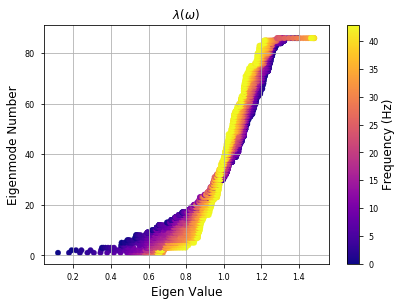

In [6]:
# define matplotlib style:
plt.style.use('seaborn-paper')

## the frequency axis needs to be shifted because it begins at 2 Hz, so our x-axis labels have to reflect that:
freq_labels = [2,5,10,15,20,25,30,35,40,45]
freq_locations = [0, 3, 8, 13, 18, 23, 28, 33, 38, 43]

# Lambda(Omega) Plot with default parameters
cmap = plt.get_cmap('plasma')
fig_lomega, ax_lomega = plt.subplots()
for i in np.arange(0,eigvalues.shape[1]):
    fig_scatter = ax_lomega.scatter(np.abs(eigvalues[:,i]),np.ones(eigvalues.shape[0])*(i+1),
                     c = np.arange(0,fvec.size), cmap = cmap)
    
ax_lomega.grid(True)
clb = fig_lomega.colorbar(fig_scatter, ax = ax_lomega)
ax_lomega.set_xlabel('Eigen Value', fontsize = 12)
ax_lomega.set_ylabel('Eigenmode Number', fontsize = 12)
ax_lomega.set_title(r'$\lambda(\omega)$', fontsize = 12)
clb.ax.set_ylabel('Frequency (Hz)', fontsize = 12)

##save figure?
#plt.savefig('eigen_spectrum.png', dpi = 300, format = 'png')
## Note Figure 1 is generated with default parameter settings

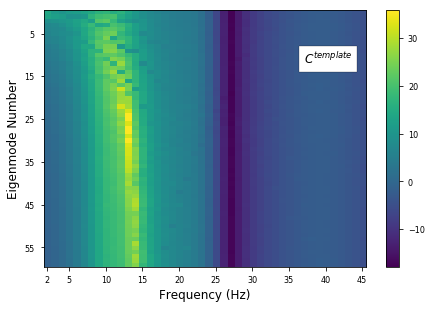

In [7]:
fig_c, ax_c = plt.subplots()
im = ax_c.imshow(functions.mag2db(np.abs(np.transpose(freq_response[:,0:60]))),aspect = 'auto')
ax_c.set_yticks(np.arange(5,60,10))
ax_c.xaxis.set_major_locator(plt.FixedLocator(freq_locations)) # shift axis because our frequency bin begins at 2 Hz
ax_c.set_xticklabels(freq_labels) # re-set axis labels
plt.ylabel('Eigenmode Number', fontsize = 12)
plt.xlabel('Frequency (Hz)', fontsize = 12)
ax_c.text(35,12, r'$C^{template}$', bbox = {'facecolor':'white','pad':5}, fontsize = 12)
plt.colorbar(im)

plt.tight_layout()
#plt.savefig('fig1E.png', dpi = 300, format = 'png')

## Load optimized parameters and recompute spectra for Figure 2:

In [8]:
## Use optmized parameters or not
## Skip this cell if you want to use default parameters.

## load optimized parameters:
opparam = loadmat(hcp_dir + '/SCFC_opparam_HCP.mat')
brain.ntf_params['tau_e'] = opparam['output']['param'][0,1][0]
brain.ntf_params['tau_i'] = opparam['output']['param'][0,1][1]
brain.ntf_params['alpha'] = opparam['output']['param'][0,1][2]
brain.ntf_params['speed'] = opparam['output']['param'][0,1][3]
brain.ntf_params['gei'] = opparam['output']['param'][0,1][4]
brain.ntf_params['gii'] = opparam['output']['param'][0,1][5]
brain.ntf_params['tauC'] = opparam['output']['param'][0,1][6]
print(brain.ntf_params)
optimized_parameters = brain.ntf_params

# with optimized parameters:
model_spectrum, freq_response, eigvalues, eigvectors = runforward.run_local_coupling_forward(brain, optimized_parameters, fvec)
print(model_spectrum.shape)

{'tau_e': array([0.01193486]), 'tau_i': array([0.00741637]), 'alpha': array([0.9670233]), 'speed': array([14.47905581]), 'gei': array([3.95527275]), 'gii': array([1.79503011]), 'tauC': array([0.00875784])}
(86, 44)


### Magnitude response of eigenmodes from different types of connectomes:

In [9]:
## individual connectome:
ind_data = loadmat(hcp_dir + '/individual_subjects.mat')
C_ind = ind_data['A_all_subjs_final'][:,:,0] # select a single subject's connectome
perm, empty, cort = individual_connectome_order()
C_ind = C_ind[perm,:][:,perm]
C_ind[empty,:] = 0
C_ind[:,empty] = 0
# create brain object
ind_brain = Brain.Brain()
ind_brain.add_connectome(hcp_dir)
ind_brain.connectome = C_ind
# re-ordering for DK atlas and normalizing the connectomes:
ind_brain.reorder_connectome(ind_brain.connectome, ind_brain.distance_matrix)
ind_brain.bi_symmetric_c()
ind_brain.reduce_extreme_dir()
_, ind_resp, _, _ = runforward.run_forward(ind_brain, optimized_parameters, fvec)
ind_magdb = functions.mag2db(np.abs(np.transpose(ind_resp[:,0:60])))

## uniform connectome:
uni_brain = Brain.Brain()
uni_brain.add_connectome(hcp_dir)
uni_brain.reducedConnectome = generate.random_Cij_und(V = 86, E = 86**2) # 86x86 random matrix with no sparsity
_, uni_resp, _, _ = runforward.run_forward(uni_brain, optimized_parameters, fvec)
uni_magdb = functions.mag2db(np.abs(np.transpose(uni_resp[:,0:60])))

## random connectome with no sparsity:
C = generate.random_Cij_und(V = 86, E = 86**2) # 86x86 random matrix with no sparsity
C = generate.add_weights(C,u = 18, s = 44) # the mean and std of hcp template connectome
# Use C
r100_brain = Brain.Brain()
r100_brain.add_connectome(hcp_dir)
r100_brain.reducedConnectome = C
_, r100_resp, _, _ = runforward.run_forward(r100_brain, optimized_parameters, fvec)
r100_magdb = functions.mag2db(np.abs(np.transpose(r100_resp[:,0:60])))

## random with 75% sparsity:
C = generate.random_Cij_und(V = 86, E = np.rint((86**2)*(1-0.75)).astype(int)) # 86x86 random matrix with 75% sparsity
C = generate.add_weights(C,u = 18, s = 44)
# Use C
r75_brain = Brain.Brain()
r75_brain.add_connectome(hcp_dir)
r75_brain.reducedConnectome = C
_, r75_resp, _, _ = runforward.run_forward(r75_brain, optimized_parameters, fvec)
r75_magdb = functions.mag2db(np.abs(np.transpose(r75_resp[:,0:60])))

## random with 95% sparsity:
C = generate.random_Cij_und(V = 86, E = np.rint((86**2)*(1-0.95)).astype(int)) # 86x86 random matrix with 75% sparsity
C = generate.add_weights(C,u = 18, s = 44)
# Use C
r95_brain = Brain.Brain()
r95_brain.add_connectome(hcp_dir)
r95_brain.reducedConnectome = C
_, r95_resp, _, _ = runforward.run_forward(r95_brain, optimized_parameters, fvec)
r95_magdb = functions.mag2db(np.abs(np.transpose(r95_resp[:,0:60])))

Plot frequency spectra first:

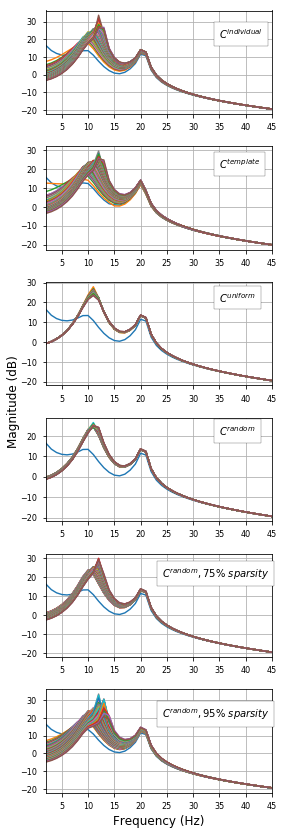

In [10]:
%matplotlib inline

font_size = 10
# subplot with 6 rows and 1 column:
with plt.style.context('seaborn-paper'):
    freqs, (f1, f2, f3, f4, f5, f6) = plt.subplots(6,1,figsize = (4.5, 12.0))
    f1.plot(fvec, functions.mag2db(np.abs(ind_resp)))
    f1.autoscale(enable=True, axis='x', tight=True)
    f1.text(35,20, r'$C^{individual}$', bbox = {'facecolor':'white','pad':5}, fontsize = font_size)
    f1.grid(True)

    f2.plot(fvec, functions.mag2db(np.abs(freq_response)))
    f2.autoscale(enable=True, axis='x', tight=True)
    f2.text(35,20, r'$C^{template}$', bbox = {'facecolor':'white','pad':5}, fontsize = font_size)
    f2.grid(True)
    
    f3.plot(fvec, functions.mag2db(np.abs(uni_resp)))
    f3.autoscale(enable=True, axis='x', tight=True)
    f3.text(35,20, r'$C^{uniform}$', bbox = {'facecolor':'white','pad':5}, fontsize = font_size)
    f3.grid(True)
    
    f4.plot(fvec, functions.mag2db(np.abs(r100_resp)))
    f4.autoscale(enable=True, axis='x', tight=True)
    f4.text(35,20, r'$C^{random}$', bbox = {'facecolor':'white','pad':5}, fontsize = font_size)
    f4.grid(True)
    
    f5.plot(fvec, functions.mag2db(np.abs(r75_resp)))
    f5.autoscale(enable=True, axis='x', tight=True)
    f5.text(24,20, r'$C^{random}, 75\%\ sparsity$', bbox = {'facecolor':'white','pad':5}, fontsize = font_size)
    f5.grid(True)
    
    f6.plot(fvec, functions.mag2db(np.abs(r95_resp)))
    f6.autoscale(enable=True, axis='x', tight=True)
    f6.text(24,20, r'$C^{random}, 95\%\ sparsity$', bbox = {'facecolor':'white','pad':5}, fontsize = font_size)
    f6.grid(True)
    f6.set_xlabel('Frequency (Hz)', fontsize = 12)
    
    freqs.add_subplot(1,1,1, frameon = False)
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    plt.ylabel('Magnitude (dB)', fontsize = 12)
    
    plt.tight_layout()
    
    ## save figure?
    #plt.savefig('freq_spectrum.png', dpi = 300, format = 'png')

Plotting heatmap of eigenmodes' magnitude per frequency:

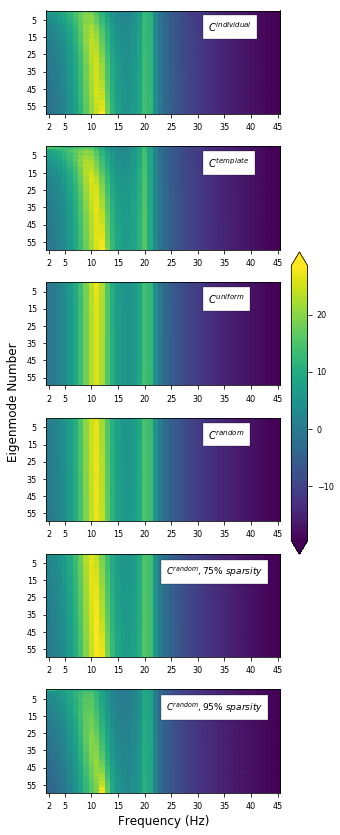

In [11]:
with plt.style.context('seaborn-paper'):
    hm, (m1,m2,m3,m4,m5,m6) = plt.subplots(6,1,figsize=(4.5,12.0))
    img = m1.imshow(ind_magdb,aspect = 'auto')
    m1.set_yticks(np.arange(5,60,10))
    m1.xaxis.set_major_locator(plt.FixedLocator(freq_locations)) # shift axis because our frequency bin begins at 2 Hz
    m1.set_xticklabels(freq_labels) # re-set axis labels
    m1.text(30,12, r'$C^{individual}$', bbox = {'facecolor':'white','pad':5}, fontsize = font_size)
    
    m2.imshow(functions.mag2db(np.abs(np.transpose(freq_response[:,0:60]))),aspect = 'auto')
    m2.set_yticks(np.arange(5,60,10))
    m2.xaxis.set_major_locator(plt.FixedLocator(freq_locations)) # shift axis because our frequency bin begins at 2 Hz
    m2.set_xticklabels(freq_labels) # re-set axis labels
    m2.text(30,12, r'$C^{template}$', bbox = {'facecolor':'white','pad':5}, fontsize = font_size)
    
    m3.imshow(uni_magdb,aspect = 'auto')
    m3.set_yticks(np.arange(5,60,10))
    m3.xaxis.set_major_locator(plt.FixedLocator(freq_locations)) # shift axis because our frequency bin begins at 2 Hz
    m3.set_xticklabels(freq_labels) # re-set axis labels
    m3.text(30,12, r'$C^{uniform}$', bbox = {'facecolor':'white','pad':5}, fontsize = font_size)
    
    m4.imshow(r100_magdb,aspect = 'auto')
    m4.set_yticks(np.arange(5,60,10))
    m4.xaxis.set_major_locator(plt.FixedLocator(freq_locations)) # shift axis because our frequency bin begins at 2 Hz
    m4.set_xticklabels(freq_labels) # re-set axis labels
    m4.text(30,12, r'$C^{random}$', bbox = {'facecolor':'white','pad':5}, fontsize = font_size)
    
    m5.imshow(r75_magdb,aspect = 'auto')
    m5.set_yticks(np.arange(5,60,10))
    m5.xaxis.set_major_locator(plt.FixedLocator(freq_locations)) # shift axis because our frequency bin begins at 2 Hz
    m5.set_xticklabels(freq_labels) # re-set axis labels
    m5.text(22,12, r'$C^{random}, 75\%\ sparsity$', bbox = {'facecolor':'white','pad':5}, fontsize = font_size-1)
    
    m6.imshow(r95_magdb,aspect = 'auto')
    m6.set_yticks(np.arange(5,60,10))
    m6.xaxis.set_major_locator(plt.FixedLocator(freq_locations)) # shift axis because our frequency bin begins at 2 Hz
    m6.set_xticklabels(freq_labels) # re-set axis labels
    m6.text(22,12, r'$C^{random}, 95\%\ sparsity$', bbox = {'facecolor':'white','pad':5}, fontsize = font_size-1)
    m6.set_xlabel('Frequency (Hz)', fontsize = 12)
    
    cbar_ax = hm.add_axes([0.97, 0.35, 0.05, 0.35])
    cb = hm.colorbar(img, cax = cbar_ax, extend = 'both')
    hm.add_subplot(1,1,1, frameon = False)
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    plt.ylabel('Eigenmode Number', fontsize = 12)

    plt.tight_layout()
    
    ## save figure?
    # plt.savefig('spectrum_heatmap.png', dpi = 300, format = 'png', bbox_inches = 'tight')